# 引言

在数据预处理中，我一般是使用Python的Pandas将其整理成整洁的长表格，输入到其它语言中进行建模计算，然后也不是输入到其它语言就可以直接用的，还需要稍微做一点处理，比较典型的包含
1. 数据框读取与类型指定;
2. 变量选择（select）;
3. 生成新变量（mutate）;
4. 数据类型转换（将数据框转换为向量或矩阵）;
5. 分组聚合;
6. 操控变形（长变宽和宽变长）;
7. 变量分布图绘制。

其中（5， 6)是重点

由于Pandas已经做好了绝大部分的数据清理工作，DataFrame.jl我们也不需要学习的太过深入，掌握上述基本操作，懂一点DataFrame.jl的基本原理即可（这些数据分析库实现的功能大同小异，基本上都差不多，增删查改，操控变形，分组聚合等等）

参考资料：
+ 中文cheetsheet
+ https://github.com/bkamins
+ https://dataframes.juliadata.org/stable/man/comparisons/#Comparison-with-the-Python-package-pandas

# DataFrame.jl

In [1]:
# 设置显示的行数和列数
Base.displaysize() = (10, 800)

In [2]:
using DataFrames
using RDatasets
using Random
using Distributions
using JupyterFormatter
enable_autoformat()

2-element Vector{Function}:
 revise (generic function with 3 methods)
 format_current_cell (generic function with 1 method)

## DataFrame类型

创建可以通过`关键字参数`，`Pair`，`矩阵`，`表格`等建立

In [3]:
DataFrame(A = 1:3, B = rand(3), C = randstring.([3, 3, 3]), fixed = 1)

,A,B,C,fixed
,Int64,Float64,String,Int64
1,1,0.0498608,Ae4,1
2,2,0.707462,JZe,1
3,3,0.292408,yYQ,1


In [4]:
DataFrame(
    Dict("A" => [1, 2], "B" => [true, false], "C" => ['a', 'b'], "fixed" => Ref([1, 1])),
)

,A,B,C,fixed
,Int64,Bool,Char,Array…
1,1,1,a,"[1, 1]"
2,2,0,b,"[1, 1]"


In [5]:
df = DataFrame(rand(3, 4), string.('a':'d'))

,a,b,c,d
,Float64,Float64,Float64,Float64
1,0.108642,0.231253,0.176124,0.0993201
2,0.839783,0.741166,0.345534,0.620847
3,0.886386,0.798349,0.698286,0.771162


In [6]:
# 将列向量转化成命名元组（Named Tuple）
nt = Tables.columntable(df)

(a = [0.10864243058920775, 0.8397833113068441, 0.8863863789980423], b = [0.23125261253685392, 0.7411664333580618, 0.7983493139950802], c = [0.17612418868415047, 0.3455336335461221, 0.6982863182155395], d = [0.09932009234940586, 0.6208471479052239, 0.7711624565492697])

In [7]:
nt.a

3-element Vector{Float64}:
 0.10864243058920775
 0.8397833113068441
 0.8863863789980423

In [8]:
nrow(df), ncol(df)

(3, 4)

In [9]:
describe(df)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,a,0.611604,0.108642,0.839783,0.886386,0,Float64
2,b,0.590256,0.231253,0.741166,0.798349,0,Float64
3,c,0.406648,0.176124,0.345534,0.698286,0,Float64
4,d,0.49711,0.0993201,0.620847,0.771162,0,Float64


In [10]:
# 获取列名
names(df)

4-element Vector{String}:
 "a"
 "b"
 "c"
 "d"

In [11]:
# 获取列名为 Symbol
propertynames(df)

4-element Vector{Symbol}:
 :a
 :b
 :c
 :d

In [12]:
# 直接获取原数据（不会copy）
df.a, df."a", df.:a, df[!, "a"], df[!, :a]

([0.10864243058920775, 0.8397833113068441, 0.8863863789980423], [0.10864243058920775, 0.8397833113068441, 0.8863863789980423], [0.10864243058920775, 0.8397833113068441, 0.8863863789980423], [0.10864243058920775, 0.8397833113068441, 0.8863863789980423], [0.10864243058920775, 0.8397833113068441, 0.8863863789980423])

In [13]:
# 复制原数据的一列
df[:, :a], df[:, "a"]

([0.10864243058920775, 0.8397833113068441, 0.8863863789980423], [0.10864243058920775, 0.8397833113068441, 0.8863863789980423])

In [14]:
first(df, 2)

,a,b,c,d
,Float64,Float64,Float64,Float64
1,0.108642,0.231253,0.176124,0.0993201
2,0.839783,0.741166,0.345534,0.620847


In [15]:
last(df, 2)

,a,b,c,d
,Float64,Float64,Float64,Float64
1,0.839783,0.741166,0.345534,0.620847
2,0.886386,0.798349,0.698286,0.771162


## 文件读取

`CSV.read("/path/to/file", DataFrame)`，读取为DataFrame

## 筛选

### 行筛选

In [16]:
subset(df, :c => c -> c .> 0.5, :d => d -> d .< 0.5)

,a,b,c,d
,Float64,Float64,Float64,Float64


### 列筛选

+ integer, vecor of integers
+ Symbol, vector of Symbols
+ string, vector of strings
+ `All()`, `Between()`, `Not()`
+ 正则表达式

In [17]:
select(df, [:a, :c, :d])

,a,c,d
,Float64,Float64,Float64
1,0.108642,0.176124,0.0993201
2,0.839783,0.345534,0.620847
3,0.886386,0.698286,0.771162


In [18]:
select(df, Between(:a, :c))

,a,b,c
,Float64,Float64,Float64
1,0.108642,0.231253,0.176124
2,0.839783,0.741166,0.345534
3,0.886386,0.798349,0.698286


In [19]:
select(df, Not(:a))

,b,c,d
,Float64,Float64,Float64
1,0.231253,0.176124,0.0993201
2,0.741166,0.345534,0.620847
3,0.798349,0.698286,0.771162


In [20]:
# 正则表达式选取
select(df, r".\d*")

,a,b,c,d
,Float64,Float64,Float64,Float64
1,0.108642,0.231253,0.176124,0.0993201
2,0.839783,0.741166,0.345534,0.620847
3,0.886386,0.798349,0.698286,0.771162


## 变量生成

In [21]:
select(df, :a => (a -> a * 1000) => :a_mean)

,a_mean
,Float64
1,108.642
2,839.783
3,886.386


In [22]:
transform(df, :a => (a -> a * 1000) => :a_mean)

,a,b,c,d,a_mean
,Float64,Float64,Float64,Float64,Float64
1,0.108642,0.231253,0.176124,0.0993201,108.642
2,0.839783,0.741166,0.345534,0.620847,839.783
3,0.886386,0.798349,0.698286,0.771162,886.386


## 分组聚合

三个函数：
+ `combine`,类似于`apply`，可以处理`df`，也可以处理`groupby(df)`,对于返回结果没有强制要求
+ `select`,类似于`transform`,可以处理`df`，也可以处理`groupby(df)`，返回结果和原DataFrame行索引一致，仅包含新生成的列
+ `transform`,类似于`transform`,可以处理`df`，也可以处理`groupby(df)`，返回结果和原DataFrame行索引一致，包含DataFrame原有的列和新生成的列

In [23]:
# 示例数据
iris = dataset("datasets", "iris")

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
,Float64,Float64,Float64,Float64,Cat…
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa
6,5.4,3.9,1.7,0.4,setosa
7,4.6,3.4,1.4,0.3,setosa
8,5.0,3.4,1.5,0.2,setosa
9,4.4,2.9,1.4,0.2,setosa


In [24]:
# 生成两列，这两列是对原来数据列的数值变换
combine(
    iris,
    :SepalLength => (c -> c * 100) => "SepalLength*100",
    :PetalLength => (c -> c / 100) => "SepalLength/100",
)

,SepalLength*100,SepalLength/100
,Float64,Float64
1,510.0,0.014
2,490.0,0.014
3,470.0,0.013
4,460.0,0.015
5,500.0,0.014
6,540.0,0.017
7,460.0,0.014
8,500.0,0.015
9,440.0,0.014


In [25]:
combine(groupby(iris, :Species), :SepalLength => (c -> first(c)) => "firstSpecies")

,Species,firstSpecies
,Cat…,Float64
1,setosa,5.1
2,versicolor,7.0
3,virginica,6.3


In [26]:
select(groupby(iris, :Species), :SepalLength => (c -> minimum(c)))

,Species,SepalLength_function
,Cat…,Float64
1,setosa,4.3
2,setosa,4.3
3,setosa,4.3
4,setosa,4.3
5,setosa,4.3
6,setosa,4.3
7,setosa,4.3
8,setosa,4.3
9,setosa,4.3


In [27]:
transform(groupby(iris, :Species), :SepalLength => (c -> first(c)))

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species,SepalLength_function
,Float64,Float64,Float64,Float64,Cat…,Float64
1,5.1,3.5,1.4,0.2,setosa,5.1
2,4.9,3.0,1.4,0.2,setosa,5.1
3,4.7,3.2,1.3,0.2,setosa,5.1
4,4.6,3.1,1.5,0.2,setosa,5.1
5,5.0,3.6,1.4,0.2,setosa,5.1
6,5.4,3.9,1.7,0.4,setosa,5.1
7,4.6,3.4,1.4,0.3,setosa,5.1
8,5.0,3.4,1.5,0.2,setosa,5.1
9,4.4,2.9,1.4,0.2,setosa,5.1


## 操控变形

两大函数：
+ `stack`, 宽变长
+ `unstack`， 长变宽

In [28]:
names(iris)

5-element Vector{String}:
 "SepalLength"
 "SepalWidth"
 "PetalLength"
 "PetalWidth"
 "Species"

In [29]:
# 宽变长
longdf = stack(
    iris,
    [:SepalLength, :SepalWidth, :PetalLength, :PetalWidth], # 取哪些变量作为值
    :Species; # 取哪些变量作为类别
    variable_name = :A_name_of_var, # 原来的值变量的列名组成的新列的列名
    value_name = :A_name_of_val, # 原来的值变量的值组成的新列的列名
)

,Species,A_name_of_var,A_name_of_val
,Cat…,String,Float64
1,setosa,SepalLength,5.1
2,setosa,SepalLength,4.9
3,setosa,SepalLength,4.7
4,setosa,SepalLength,4.6
5,setosa,SepalLength,5.0
6,setosa,SepalLength,5.4
7,setosa,SepalLength,4.6
8,setosa,SepalLength,5.0
9,setosa,SepalLength,4.4


In [30]:
l2 = combine(
    groupby(iris, :Species),
    Between(:SepalLength, :PetalWidth) .=> first;
    renamecols = false,
)
longdf2 = stack(
    l2,
    Between(:SepalLength, :PetalWidth),
    :Species;
    variable_name = :feature,
    value_name = :value,
)

,Species,feature,value
,Cat…,String,Float64
1,setosa,SepalLength,5.1
2,versicolor,SepalLength,7.0
3,virginica,SepalLength,6.3
4,setosa,SepalWidth,3.5
5,versicolor,SepalWidth,3.2
6,virginica,SepalWidth,3.3
7,setosa,PetalLength,1.4
8,versicolor,PetalLength,4.7
9,virginica,PetalLength,6.0


In [31]:
# Species不能有重复项
unstack(longdf2, :Species, :feature, :value; allowduplicates = false)

,Species,SepalLength,SepalWidth,PetalLength,PetalWidth
,Cat…,Float64?,Float64?,Float64?,Float64?
1,setosa,5.1,3.5,1.4,0.2
2,versicolor,7.0,3.2,4.7,1.4
3,virginica,6.3,3.3,6.0,2.5


## 绘图
Julia统计绘图好拉胯

In [32]:
using CairoMakie

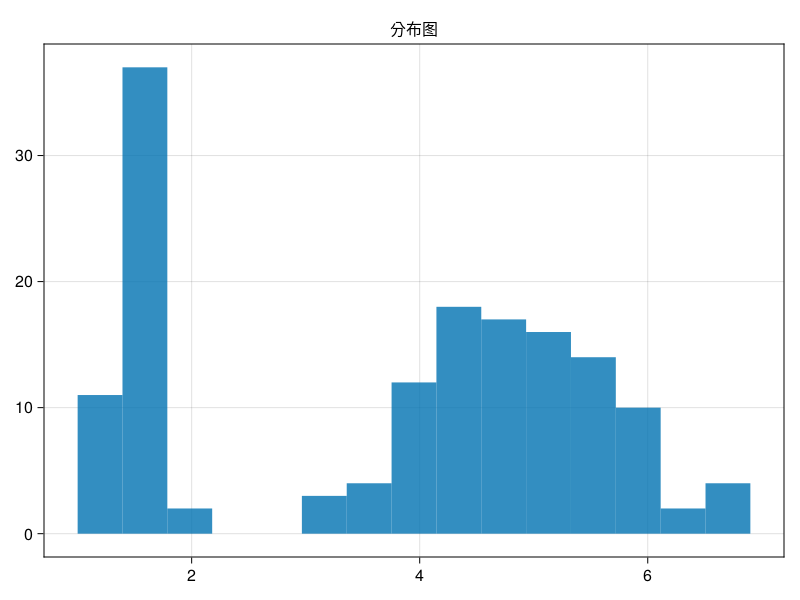

In [33]:
f = Figure()
ax = Axis(f[1, 1], title = "分布图")
hist!(ax, iris.PetalLength)
f